# [final] text-to-coloring_pages(1)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1fGAo6fKv1T266lw12RLB1gA7WXY-74i8?usp=sharing)


코드 수정 없이 진행하려면 구글 드라이브 내부에 'pix2pix'폴더가 있고,  'pix2pix'폴더 내부에는 Pix2Pix_Generator_V1(100e).pt와 Pix2Pix_Generator_V2(125e).pt 2개의 모델이 들어있는 'trained_model' 폴더가 있어야 함.

해당 trained model은 https://github.com/juneshuai/DataProject/tree/main/pix2pix/trained_model 혹은 https://drive.google.com/drive/folders/1W0SsokziLlcHnCmOSAg9Ns55uS5iQQTj?usp=sharing 에서 다운로드 할 수 있음. 


# 0.구글 드라이브 마운트


In [ ]:
from google.colab import drive
drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1.필요 라이브러리 install

In [ ]:
#명사추출을 위해 필요한 라이브러리 모음
!pip install sentence_transformers
!pip install konlpy
!pip install -q jmd_imagescraper

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# 2.필요한 라이브러리 불러오기, 함수, 모델 정의하기

In [ ]:
#konlpy랑 papago translate위한 라이브러리, 함수

import numpy as np
import itertools

from konlpy.tag import Okt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer

import requests

#번역 함수
def get_translate(text): 
    client_id = "VS68zCj4KvXKRD7avvi6" #@param {type:"string"}
    client_secret = "WYDQls3eBJ" #@param {type:"string"}

    data = {'text' : text,
            'source' : 'ko',
            'target': 'en'}

    url = "https://openapi.naver.com/v1/papago/n2mt"

    header = {"X-Naver-Client-Id":client_id,
              "X-Naver-Client-Secret":client_secret}

    response = requests.post(url, headers=header, data=data)
    rescode = response.status_code

    if(rescode==200):
        send_data = response.json()
        trans_data = (send_data['message']['result']['translatedText'])
        return trans_data
    else:
        print("Error Code:" , rescode)

In [ ]:
# 이미지 폴더, 파일 읽기 위한 라이브러리, 함수

from __future__ import print_function
import argparse

from torch.autograd import Variable

import os
from PIL import Image
import PIL.Image
import PIL.ImageTk
import cv2
from google.colab.patches import cv2_imshow
from IPython.display import Image

# 확장자로 이미지 파일인지 확인하는 함수
def is_image_file(filename):
    return any(filename.endswith(extension) for extension in [".png", ".jpg", ".jpeg"])

# rgb, 사이즈 맞춰서 이미지 가져오는 함수
def load_img(filepath): 
    img = PIL.Image.open(filepath).convert('RGB')
    img = img.resize((256, 256))
    return img

# 이미지 저장하는 함수
def save_img(image_tensor, filename):
    image_numpy = image_tensor.float().numpy()
    image_numpy = (np.transpose(image_numpy, (1, 2, 0)) + 1) / 2.0 * 255.0
    image_numpy = image_numpy.astype(np.uint8)
    image_pil = Image.fromarray(image_numpy)
    image_pil.save(filename)
    print("Image saved as {}".format(filename))

In [ ]:
#모델 정의

import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.utils import save_image

# U-Net 아키텍처의 다운 샘플링(Down Sampling) 모듈
class UNetDown(nn.Module):
    def __init__(self, in_channels, out_channels, normalize=True, dropout=0.0):
        super(UNetDown, self).__init__()
        # 너비와 높이가 2배씩 감소
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False)]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2))
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


# U-Net 아키텍처의 업 샘플링(Up Sampling) 모듈: Skip Connection 사용
class UNetUp(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.0):
        super(UNetUp, self).__init__()
        # 너비와 높이가 2배씩 증가
        layers = [nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False)]
        layers.append(nn.InstanceNorm2d(out_channels))
        layers.append(nn.ReLU(inplace=True))
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip_input):
        x = self.model(x)
        x = torch.cat((x, skip_input), 1) # 채널 레벨에서 합치기(concatenation)

        return x


# U-Net 생성자(Generator) 아키텍처
class GeneratorUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(GeneratorUNet, self).__init__()

        self.down1 = UNetDown(in_channels, 64, normalize=False) # 출력: [64 X 128 X 128]
        self.down2 = UNetDown(64, 128) # 출력: [128 X 64 X 64]
        self.down3 = UNetDown(128, 256) # 출력: [256 X 32 X 32]
        self.down4 = UNetDown(256, 512, dropout=0.5) # 출력: [512 X 16 X 16]
        self.down5 = UNetDown(512, 512, dropout=0.5) # 출력: [512 X 8 X 8]
        self.down6 = UNetDown(512, 512, dropout=0.5) # 출력: [512 X 4 X 4]
        self.down7 = UNetDown(512, 512, dropout=0.5) # 출력: [512 X 2 X 2]
        self.down8 = UNetDown(512, 512, normalize=False, dropout=0.5) # 출력: [512 X 1 X 1]

        # Skip Connection 사용(출력 채널의 크기 X 2 == 다음 입력 채널의 크기)
        self.up1 = UNetUp(512, 512, dropout=0.5) # 출력: [1024 X 2 X 2]
        self.up2 = UNetUp(1024, 512, dropout=0.5) # 출력: [1024 X 4 X 4]
        self.up3 = UNetUp(1024, 512, dropout=0.5) # 출력: [1024 X 8 X 8]
        self.up4 = UNetUp(1024, 512, dropout=0.5) # 출력: [1024 X 16 X 16]
        self.up5 = UNetUp(1024, 256) # 출력: [512 X 32 X 32]
        self.up6 = UNetUp(512, 128) # 출력: [256 X 64 X 64]
        self.up7 = UNetUp(256, 64) # 출력: [128 X 128 X 128]

        self.final = nn.Sequential(
            nn.Upsample(scale_factor=2), # 출력: [128 X 256 X 256]
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(128, out_channels, kernel_size=4, padding=1), # 출력: [3 X 256 X 256]
            nn.Tanh(),
        )

    def forward(self, x):
        # 인코더부터 디코더까지 순전파하는 U-Net 생성자(Generator)
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)
        u1 = self.up1(d8, d7)
        u2 = self.up2(u1, d6)
        u3 = self.up3(u2, d5)
        u4 = self.up4(u3, d4)
        u5 = self.up5(u4, d3)
        u6 = self.up6(u5, d2)
        u7 = self.up7(u6, d1)

        return self.final(u7)


# U-Net 판별자(Discriminator) 아키텍처
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()

        def discriminator_block(in_channels, out_channels, normalization=True):
            # 너비와 높이가 2배씩 감소
            layers = [nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)]
            if normalization:
                layers.append(nn.InstanceNorm2d(out_channels))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            # 두 개의 이미지(실제/변환된 이미지, 조건 이미지)를 입력 받으므로 입력 채널의 크기는 2배
            *discriminator_block(in_channels * 2, 64, normalization=False), # 출력: [64 X 128 X 128]
            *discriminator_block(64, 128), # 출력: [128 X 64 X 64]
            *discriminator_block(128, 256), # 출력: [256 X 32 X 32]
            *discriminator_block(256, 512), # 출력: [512 X 16 X 16]
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, kernel_size=4, padding=1, bias=False) # 출력: [1 X 16 X 16]
        )

    # img_A: 실제/변환된 이미지, img_B: 조건(condition)
    def forward(self, img_A, img_B):
        # 이미지 두 개를 채널 레벨에서 연결하여(concatenate) 입력 데이터 생성
        img_input = torch.cat((img_A, img_B), 1)
        return self.model(img_input)




def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


transforms_ = transforms.Compose([
    transforms.Resize((256, 256), Image.BICUBIC), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:333: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "


# 3.모델 불러오기

In [ ]:
#@markdown #**사용할 모델 선택**
#@markdown ---

#@markdown v1(100e)와 v2(125e) 중에 사용할 모델을 선택해 실행. 둘 중 하나만 선택해야 함.

#@markdown ---
V1_100e = True #@param {type:"boolean"}
V2_125e = False #@param {type:"boolean"}

#모델 불러오기 (사용할 때에는 generator만 있으면 됨)
%cd /content/drive/MyDrive/pix2pix/trained_model

generator = GeneratorUNet()
generator.cuda()

if V1_100e:
    generator.load_state_dict(torch.load("Pix2Pix_Generator_V1(100e).pt")) #v1(100e)

if V2_125e:
    generator.load_state_dict(torch.load("Pix2Pix_Generator_V2(125e).pt")) #v2(125e)

/content/drive/MyDrive/pix2pix/trained_model


# 4.텍스트 넣기

텍스트가 단어~여러문장으로 들어오면 명사추출을 진행하고 그 추출된 키워드로 2장의 이미지 크롤링, 학습시킨 pix2pix모델로 컬러링 도안화함.

/content
Duckduckgo search: simple illustration of Fox


Namespace(cuda=True, dataset='illustration', model='Pix2Pix_Generator_V2(125e).pt')


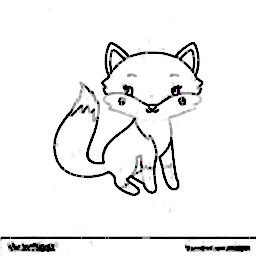

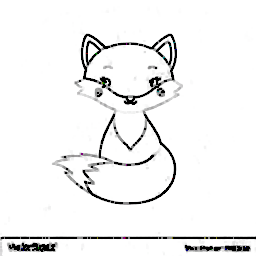

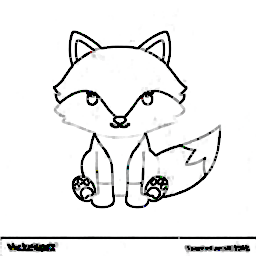

In [ ]:
#@markdown #**맞춤질문: ex)이솝우화 읽고 있었구나,, @@는 제일 좋아하는 동물이 뭐에요?**
#@markdown ---
doc = "\uC5EC\uC6B0\uC694! \uB611\uB611\uD558\uACE0 \uBA4B\uC788\uC5B4\uC694"#@param {type:"string"}

%cd /content/
okt = Okt()

tokenized_doc = okt.pos(doc)
tokenized_nouns = ' '.join([word[0] for word in tokenized_doc if word[1] == 'Noun'])

n_gram_range = (0,1)

count = CountVectorizer(ngram_range=n_gram_range).fit([tokenized_nouns])
candidates = count.get_feature_names_out()



#trigram 명사추출 한번에 검색어로

from pathlib import Path
root = Path().cwd()/"input_img"

from jmd_imagescraper.core import *

params = {
    "max_results": 3,             
    "img_size":    ImgSize.Cached, 
    "img_type":    ImgType.Photo,
    "img_layout":  ImgLayout.Square,
    "img_color":   ImgColor.All
}

candidate_e = get_translate(candidates)
duckduckgo_search(root, "{}".format(candidate_e), "simple illustration of {}".format(candidate_e), **params)


parser = argparse.ArgumentParser()
parser.add_argument('--dataset', required=False, default='illustration', help='illustration')
parser.add_argument('--model', required=False, type=str, default='Pix2Pix_Generator_V2(125e).pt', help='model file to use')
parser.add_argument('--cuda', action='store_true', default=True, help='use cuda')
params = parser.parse_args([])
print(params)

#[폴더][폴더]구조에서 개별 파일 로드를 위한 '하위폴더/파일이름' 찾기 
target_imagefolder = "/content/input_img/{}".format(candidate_e) #[폴더]로 구성돼 있는 원본 이미지 데이터셋 경로지정

image_dir = target_imagefolder.format(params.dataset)
image_filenames = [x for x in os.listdir(image_dir) if is_image_file(x)]


for image_name in image_filenames:
    imgs = load_img("{}/{}".format(target_imagefolder, image_name))
    imgs = transforms_(imgs)

    input = Variable(imgs).view(1,-1,256,256)
    input_img = input.data[0]
    save_image(input_img, "input.png", nrow=1, normalize=True)
    input_img = cv2.imread("input.png", cv2.IMREAD_GRAYSCALE) #이미지 전처리(1): 흑백으로 전환
    
    if params.cuda:
        generator = generator.cuda()
        input = input.cuda()

    out = generator(input)
    out = out.cpu()
    out_img = out.data[0]
    save_image(out_img, "result.png", nrow=1, normalize=True)

    out_img = cv2.imread("result.png");
    th, out_img = cv2.threshold(out_img, 127,255, cv2.THRESH_TOZERO) #이미지 후처리(1): 임계처리

    kernel = np.ones((2,2), 'uint8')
    out_img = cv2.erode(out_img, kernel, iterations=1) #이미지 후처리(2): erode처리

    cv2_imshow(out_img)

    cv2.imwrite('/content/{}'.format(image_name), out_img) #일단 content에 저장하게 했습니다.